let us first import all the libraries we'll be using

In [155]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report)
import matplotlib.pyplot as plt
import numpy as np

let us now load the data

In [156]:
df = pd.read_csv("cleaned_data.csv")
# create copy of the DataFrame
df = df.copy()
X = df.drop("income", axis=1)
y = df["income"].apply(lambda x: 1 if x.strip() == ">50k" else 0)

locating the categorical columns

In [157]:

categorical_cols = X.select_dtypes(include="object").columns.tolist()

building the pipeline

In [158]:
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)],
    remainder="passthrough"
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

perform test train split and train your model

In [159]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

let us see how our model performed

Accuracy: 0.8170731707317073
Precision: 0.6224556795797768
Recall: 0.6143875567077123
F1 Score: 0.6183953033268101

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      4853
           1       0.62      0.61      0.62      1543

    accuracy                           0.82      6396
   macro avg       0.75      0.75      0.75      6396
weighted avg       0.82      0.82      0.82      6396



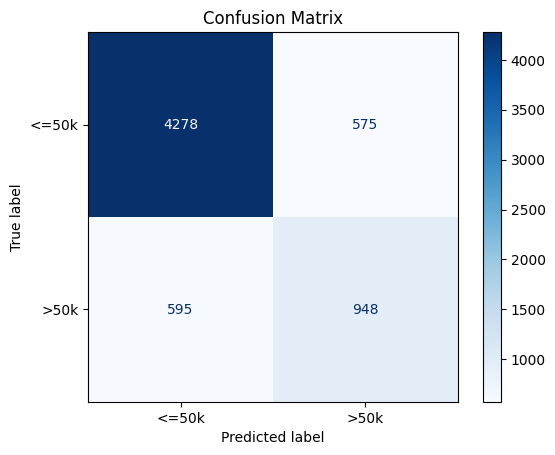


Decision Tree Hyperparameters:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


In [160]:
# ...existing code...

from sklearn.metrics import ConfusionMatrixDisplay
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plotting the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["<=50k", ">50k"], cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

print("\nDecision Tree Hyperparameters:")
print(pipeline.named_steps["classifier"].get_params())

let us visualize our tree

In [161]:
plt.figure(figsize=(20, 10))

ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
encoded_cols = ohe.get_feature_names_out(categorical_cols)
all_feature_names = list(encoded_cols) + X.select_dtypes(exclude="object").columns.tolist()

# Access trained tree from pipeline
tree = pipeline.named_steps["classifier"]

# plot_tree(tree,
#           feature_names=all_feature_names,
#           class_names=["<=50k", ">50k"],
#           filled=True,
#           rounded=True,
#           fontsize=10)

# plt.title("Decision Tree (max_depth=3)")
# plt.show()

<Figure size 2000x1000 with 0 Axes>

as we can see this is very much clutterred file we eed to refine it by removing some of the unneccessary variables from it for that we first need to identify which ones are neccessary

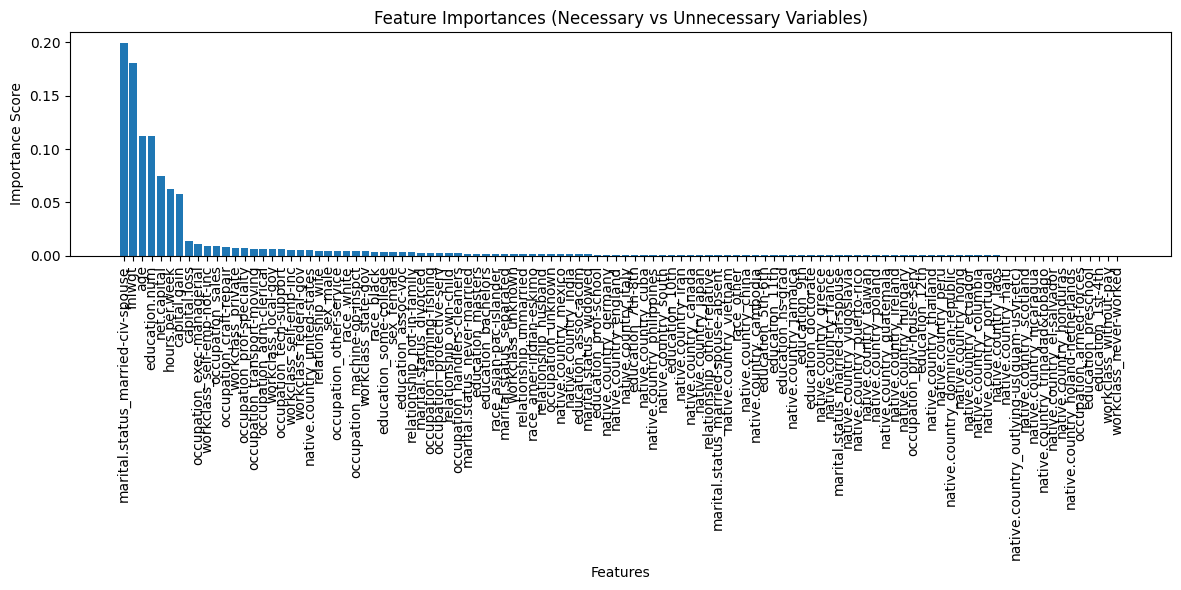

In [162]:
ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
encoded_cols = ohe.get_feature_names_out(categorical_cols)
all_feature_names = list(encoded_cols) + X.select_dtypes(exclude="object").columns.tolist()


importances = pipeline.named_steps["classifier"].feature_importances_

indices = np.argsort(importances)[::-1]
sorted_features = [all_feature_names[i] for i in indices]
sorted_importances = importances[indices]

plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_features)), sorted_importances, align="center")
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.title("Feature Importances (Necessary vs Unnecessary Variables)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

let us print them out

In [163]:
threshold = 0.01
important_vars = [(feature, score) for feature, score in zip(all_feature_names, importances) if score > threshold]

print("Important variables (importance > {:.2f}):".format(threshold))
for feature, score in important_vars:
    print(f"{feature}: {score:.4f}")

Important variables (importance > 0.01):
marital.status_married-civ-spouse: 0.1995
occupation_exec-managerial: 0.0110
age: 0.1123
fnlwgt: 0.1808
education.num: 0.1122
capital.gain: 0.0582
capital.loss: 0.0139
hours.per.week: 0.0621
net.capital: 0.0747



Important Features Model Evaluation:
Accuracy: 0.8117573483427142


<Figure size 800x600 with 0 Axes>

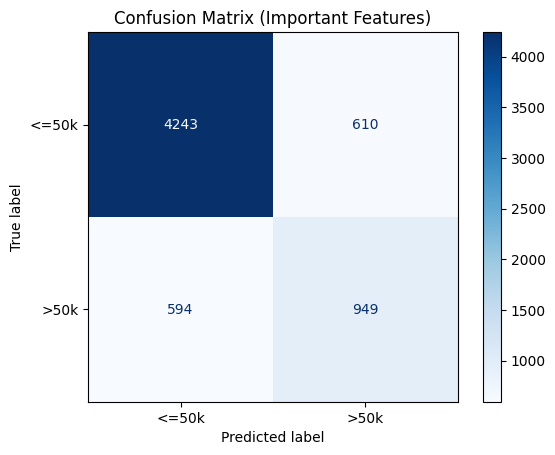

In [164]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# Correct list of original (pre-encoded) feature names
important_features = [
    "marital.status",
    "occupation",
    "age",
    "fnlwgt",
    "education.num",
    "capital.gain",
    "capital.loss",
    "hours.per.week",
    "net.capital"
]

# Filter original DataFrame using valid column names
X_important = X[important_features]

# Split data
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_important, y, test_size=0.2, random_state=42
)

# Build preprocessor for just categorical columns in the subset
categorical_subset = X_important.select_dtypes(include="object").columns.tolist()
preprocessor_imp = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_subset)],
    remainder="passthrough"
)

# Build pipeline with simplified preprocessor
pipeline_imp = Pipeline(steps=[
    ("preprocessor", preprocessor_imp),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

# Train and evaluate
pipeline_imp.fit(X_train_imp, y_train_imp)
y_pred_imp = pipeline_imp.predict(X_test_imp)

# Evaluation
print("\nImportant Features Model Evaluation:")
print("Accuracy:", accuracy_score(y_test_imp, y_pred_imp))

# Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test_imp, y_pred_imp, display_labels=["<=50k", ">50k"], cmap="Blues")
plt.title("Confusion Matrix (Important Features)")
plt.show()
